# Importing modules, preprocessing


In [9]:
#Importing the required modules, the ones I remember
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [10]:
import io
dataRequired = pd.read_csv("/content/DatasetForForecastingSIH.csv")
dataRequired.head()

,Unnamed: 0,index,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal
0,0,87656,7035.0,6343.0,36.0,2.0,109.0,3.27,-4.179,1.5614,25.9639
1,1,87657,7394.0,6882.0,41.0,10.0,146.0,3.23,-2.807,7.5467,75.0443
2,2,87658,7770.0,6963.0,45.0,21.0,146.0,3.22,-1.315,17.2073,116.9171
3,3,87659,7820.0,7110.0,50.0,32.0,158.0,3.22,-0.051,35.4289,146.8923
4,4,87660,7694.0,7136.0,51.0,37.0,187.0,3.00,0.791,58.5238,151.4721


In [11]:
dataRequired.shape

(17488, 11)

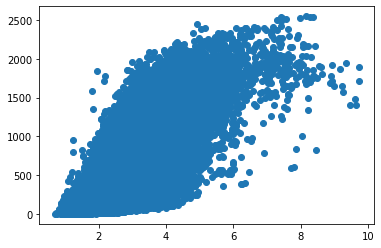

In [12]:
#Plotting and visualising the time series relation
plt.scatter(dataRequired['AT_windspeed_10m'],dataRequired['AT_wind_onshore_generation_actual'])

In [13]:
#Clearly, the characteristics resemble the expected characteristics, but the data had quite a bit of deviation about the standard curve.
#It can be clearly attributed to variations in density of the air density, due to radiation changes throughout the year.

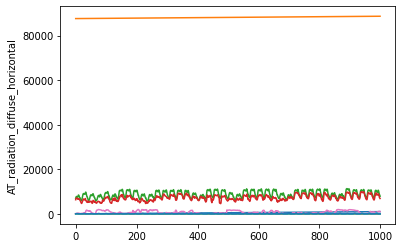

In [14]:
#Plotting the time series
for i in dataRequired:
  plt.ylabel(i)
  plt.plot(dataRequired[i][:1000])

In [15]:
# Certain periodic trends are found in the data, also, the series appear sufficiently correlated with one another, we thus use an LSTM for training the model

In [16]:
#Converting the time series analysis problem into a supervised learning problem
def seriesToSupervised(data, lookBack = 60, predCols = 1):
  temp = data.copy()
  temp['id'] = range(1, len(temp)+1)
  temp = temp.iloc[: -lookBack, :]
  temp.set_index('id', inplace = True)
  predVal = data.copy()
  predVal = predVal.iloc[lookBack:, predCols]
  predVal.columns = ['Pred']
  predVal = pd.DataFrame(predVal)
  predVal['id'] = range(1, len(predVal)+1)
  predVal.set_index('id', inplace = True)
  finalDf = pd.concat([temp, predVal], axis = 1)
  return finalDf

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Solar energy output forecasting



In [18]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredSolarOutput=dataRequired[['AT_solar_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredSolarOutput['pred'] = dataPredSolarOutput['AT_solar_generation_actual'].shift(-1)
dataPredSolarOutput = dataPredSolarOutput.dropna()
dataPredSolarOutput.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_solar_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,2.0,3.27,-4.179,1.5614,25.9639,10.0
1,10.0,3.23,-2.807,7.5467,75.0443,21.0
2,21.0,3.22,-1.315,17.2073,116.9171,32.0
3,32.0,3.22,-0.051,35.4289,146.8923,37.0
4,37.0,3.00,0.791,58.5238,151.4721,35.0


In [19]:
scalerOne = MinMaxScaler(feature_range=(0,1))
solarScaled = scalerOne.fit_transform(dataPredSolarOutput.values)
solarScaled = pd.DataFrame(solarScaled)

In [20]:
solarScaled.head()

,0,1,2,3,4,5
0,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393
1,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426
2,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459
3,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656
4,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377


In [21]:
arrDfSolar = seriesToSupervised(solarScaled, 3, 0)
arrDfSolar.fillna(0, inplace = True)
arrDfSolar.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393,0.052459
2,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426,0.060656
3,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459,0.057377
4,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656,0.044262
5,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377,0.022951


In [22]:
# splitting and converting the data to right shape, around 80:20 ratio would be good for validation
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [23]:
# We need a 3D data as (sample size, look back steps, input features)
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [24]:
model = Sequential()
model.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 30))
model.add(Dense(units = 1))
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 75)             24600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             25200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 4s 318us/step - loss: 0.0810 - val_loss: 0.1119
Epoch 2/50
11191/11191 [==============================] - 2s 169us/step - loss: 0.0418 - val_loss: 0.0698
Epoch 3/50
11191/11191 [==============================] - 2s 168us/step - loss: 0.0372 - val_loss: 0.0587
Epoch 4/50
11191/11191 [==============================] - 2s 164us/step - loss: 0.0352 - val_loss: 0.0643
Epoch 5/50
11191/11191 [==============================] - 2s 165us/step - loss: 0.0349 - val_loss: 0.0635
Epoch 6/50
11191/11191 [==============================] - 2s 169us/step - loss: 0.0345 - val_loss: 0.0548
Epoch 7/50
11191/11191 [==============================] - 2s 169us/step - loss: 0.0343 - val_loss: 0.0576
Epoch 8/50
11191/11191 [==============================] - 2s 167us/step - loss: 0.0348 - val_loss: 0.0511
Epoch 9/50
11191/11191 [==============================] - 2s 167us/step - loss: 0.0338 - val_loss: 0.05

In [26]:
#Making predictions
yPred = model.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerOne.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerOne.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 17.12198905355333
Mean squared error 765.3741714353862
R2_Score 0.9597208529168


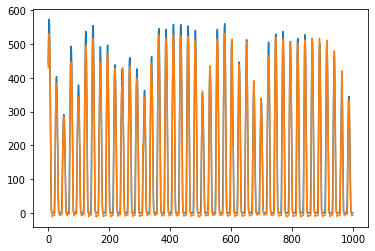

In [27]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

# Wind energy output forecasting


In [28]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredWindOutput = dataRequired[['AT_wind_onshore_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredWindOutput['pred'] = dataPredWindOutput['AT_wind_onshore_generation_actual'].shift(-1)
dataPredWindOutput = dataPredWindOutput.dropna()
dataPredWindOutput.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,109.0,3.27,-4.179,1.5614,25.9639,146.0
1,146.0,3.23,-2.807,7.5467,75.0443,146.0
2,146.0,3.22,-1.315,17.2073,116.9171,158.0
3,158.0,3.22,-0.051,35.4289,146.8923,187.0
4,187.0,3.00,0.791,58.5238,151.4721,244.0


In [29]:
scalerTwo = MinMaxScaler(feature_range=(0,1))
windScaled = scalerTwo.fit_transform(dataPredWindOutput.values)
windScaled = pd.DataFrame(windScaled)
windScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [30]:
arrDfWind = seriesToSupervised(windScaled, 3, 0)
arrDfWind.fillna(0, inplace = True)
arrDfWind.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [31]:
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [32]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [33]:
modelOne = Sequential()
modelOne.add(LSTM(128, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelOne.add(LSTM(units = 64, return_sequences=True))
modelOne.add(LSTM(units = 32))
modelOne.add(Dense(units = 1))
modelOne.compile(loss = 'mae', optimizer = 'adam')
modelOne.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            69120     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = modelOne.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 309us/step - loss: 0.0862 - val_loss: 0.0609
Epoch 2/50
11191/11191 [==============================] - 2s 197us/step - loss: 0.0592 - val_loss: 0.0562
Epoch 3/50
11191/11191 [==============================] - 2s 206us/step - loss: 0.0563 - val_loss: 0.0543
Epoch 4/50
11191/11191 [==============================] - 2s 203us/step - loss: 0.0540 - val_loss: 0.0519
Epoch 5/50
11191/11191 [==============================] - 2s 201us/step - loss: 0.0525 - val_loss: 0.0502
Epoch 6/50
11191/11191 [==============================] - 2s 213us/step - loss: 0.0515 - val_loss: 0.0528
Epoch 7/50
11191/11191 [==============================] - 2s 199us/step - loss: 0.0508 - val_loss: 0.0544
Epoch 8/50
11191/11191 [==============================] - 2s 202us/step - loss: 0.0503 - val_loss: 0.0559
Epoch 9/50
11191/11191 [==============================] - 2s 198us/step - loss: 0.0502 - val_loss: 0.05

In [35]:
#Making predictions
yPred = modelOne.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerTwo.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerTwo.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 107.4077821757234
Mean squared error 28002.538400330763
R2_Score 0.9298159091719198


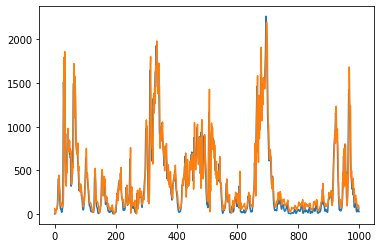

In [36]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

# Demand forecasting model



In [37]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredDemand = dataRequired[['AT_load_actual_entsoe_power_statistics', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredDemand['pred'] = dataPredDemand['AT_load_actual_entsoe_power_statistics'].shift(-1)
dataPredDemand = dataPredDemand.dropna()
dataPredDemand.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_load_actual_entsoe_power_statistics,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,7035.0,3.27,-4.179,1.5614,25.9639,7394.0
1,7394.0,3.23,-2.807,7.5467,75.0443,7770.0
2,7770.0,3.22,-1.315,17.2073,116.9171,7820.0
3,7820.0,3.22,-0.051,35.4289,146.8923,7694.0
4,7694.0,3.00,0.791,58.5238,151.4721,7565.0


In [38]:
scalerThree = MinMaxScaler(feature_range=(0,1))
demandScaled = scalerThree.fit_transform(dataPredDemand.values)
demandScaled = pd.DataFrame(windScaled)
demandScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [39]:
arrDfDemand = seriesToSupervised(demandScaled, 3, 0)
arrDfDemand.fillna(0, inplace = True)
arrDfDemand.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [40]:
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [41]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [42]:
modelTwo = Sequential()
modelTwo.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelTwo.add(LSTM(units = 50, return_sequences=True))
modelTwo.add(LSTM(units = 30))
modelTwo.add(Dense(units = 1))
modelTwo.compile(loss = 'mae', optimizer = 'adam')
modelTwo.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 75)             24600     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 50)             25200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = modelTwo.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 273us/step - loss: 0.0934 - val_loss: 0.0609
Epoch 2/50
11191/11191 [==============================] - 2s 161us/step - loss: 0.0588 - val_loss: 0.0572
Epoch 3/50
11191/11191 [==============================] - 2s 160us/step - loss: 0.0562 - val_loss: 0.0550
Epoch 4/50
11191/11191 [==============================] - 2s 164us/step - loss: 0.0542 - val_loss: 0.0527
Epoch 5/50
11191/11191 [==============================] - 2s 162us/step - loss: 0.0526 - val_loss: 0.0511
Epoch 6/50
11191/11191 [==============================] - 2s 162us/step - loss: 0.0513 - val_loss: 0.0502
Epoch 7/50
11191/11191 [==============================] - 2s 162us/step - loss: 0.0501 - val_loss: 0.0528
Epoch 8/50
11191/11191 [==============================] - 2s 159us/step - loss: 0.0498 - val_loss: 0.0539
Epoch 9/50
11191/11191 [==============================] - 2s 163us/step - loss: 0.0497 - val_loss: 0.05

In [44]:
#Making predictions
yPred = modelTwo.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerThree.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerThree.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 296.13222801484613
Mean squared error 213954.0131697989
R2_Score 0.9301767589883283


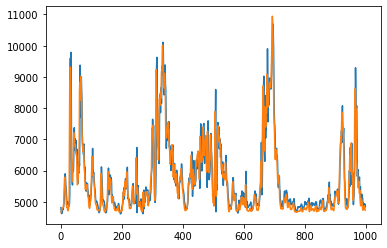

In [45]:
plt.plot(invyPred[:1000])
plt.plot(invyTest[:1000])

# Uploading the model parameters to drive



In [46]:
model.save('/content/drive/My Drive/SolarEnergyGenerationForecasting.h5')

OSError: ignored

In [ ]:
modelOne.save('/content/drive/My Drive/WinEnergyGenerationForecasting.h5')

In [ ]:
modelTwo.save('/content/drive/My Drive/DemandForecasting.h5')

# Scheduling algorithm


In [48]:
#Having the data in hand and in the right format

In [49]:
#Demand model input
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
testDemand = values[trainSample:, :]
XTestDemand, yTestDemand = testDemand[:,:-1], testDemand[:, -1]
XTestDemand = XTestDemand.reshape((XTestDemand.shape[0], 1, XTestDemand.shape[1]))
XTestDemand.shape, yTestDemand.shape

((3495, 1, 6), (3495,))

In [50]:
# #The test demand shall be split into 24 hour intervals
# yPredDemand = modelTwo.predict(XTestDemand)
# XTestDemand = XTestDemand.reshape((XTestDemand.shape[0],XTestDemand.shape[2]))
# invyPredDemand = np.concatenate((yPredDemand, XTestDemand[:, 1:]), axis = 1)
# invyPredDemand = scalerThree.inverse_transform(invyPredDemand)
# invyPredDemand = invyPredDemand[:, 0]

# yTestDemand = yTestDemand.reshape((len(yTestDemand), 1))
# invyTestDemand = np.concatenate((yTestDemand, XTestDemand[:, 1:]), axis = 1)
# invyTestDemand = scalerThree.inverse_transform(invyTestDemand)
# invyTestDemand = invyTestDemand[:, 0]

In [51]:
#Wind Energy supply
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
testWind = values[trainSample:, :]
XTestWind, yTestWind = testWind[:,:-1], testWind[:, -1]
XTestWind = XTestWind.reshape((XTestWind.shape[0], 1, XTestWind.shape[1]))
XTestWind.shape, yTestWind.shape

((3495, 1, 6), (3495,))

In [52]:
# #The test wind shall be split into 24 hours
# yPredWind = modelOne.predict(XTestWind)
# XTestWind = XTestWind.reshape((XTestWind.shape[0],XTestWind.shape[2]))
# invyPredWind = np.concatenate((yPredWind, XTestWind[:, 1:]), axis = 1)
# invyPredWind = scalerTwo.inverse_transform(invyPredWind)
# invyPredWind = invyPredWind[:, 0]

# yTestWind = yTestWind.reshape((len(yTestWind), 1))
# invyTestWind = np.concatenate((yTestWind, XTestWind[:, 1:]), axis = 1)
# invyTestWind = scalerTwo.inverse_transform(invyTestWind)
# invyTestWind = invyTestWind[:, 0]

In [53]:
#Solar Energy supply
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
testSolar = values[trainSample:, :]
XTestSolar, yTestSolar = testSolar[:,:-1], testSolar[:, -1]
XTestSolar = XTestSolar.reshape((XTestSolar.shape[0], 1, XTestSolar.shape[1]))
XTestSolar.shape, yTestSolar.shape

((3495, 1, 6), (3495,))

In [54]:
# #The test solar shall be split into 24 hour intervals
# yPredSolar = model.predict(XTestSolar)
# XTestSolar = XTestSolar.reshape((XTestSolar.shape[0],XTestSolar.shape[2]))
# invyPredSolar = np.concatenate((yPredSolar, XTestSolar[:, 1:]), axis = 1)
# invyPredSolar = scalerOne.inverse_transform(invyPredSolar)
# invyPredSolar = invyPredSolar[:, 0]

# yTestSolar = yTestSolar.reshape((len(yTestSolar), 1))
# invyTestSolar = np.concatenate((yTestSolar, XTestSolar[:, 1:]), axis = 1)
# invyTestSolar = scalerOne.inverse_transform(invyTestSolar)
# invyTestSolar = invyTestSolar[:, 0]

In [55]:
XTestSolar.shape, XTestDemand.shape, XTestWind.shape

((3495, 1, 6), (3495, 1, 6), (3495, 1, 6))

In [56]:
def weightMatrix():
  array = []
  for i in range(99):
    array.append(1/(10+5*i))
  array.append(1-sum(array))
  return array

In [57]:
weighs = weightMatrix()
weighs

[0.1,
 0.06666666666666667,
 0.05,
 0.04,
 0.03333333333333333,
 0.02857142857142857,
 0.025,
 0.022222222222222223,
 0.02,
 0.01818181818181818,
 0.016666666666666666,
 0.015384615384615385,
 0.014285714285714285,
 0.013333333333333334,
 0.0125,
 0.011764705882352941,
 0.011111111111111112,
 0.010526315789473684,
 0.01,
 0.009523809523809525,
 0.00909090909090909,
 0.008695652173913044,
 0.008333333333333333,
 0.008,
 0.007692307692307693,
 0.007407407407407408,
 0.007142857142857143,
 0.006896551724137931,
 0.006666666666666667,
 0.0064516129032258064,
 0.00625,
 0.006060606060606061,
 0.0058823529411764705,
 0.005714285714285714,
 0.005555555555555556,
 0.005405405405405406,
 0.005263157894736842,
 0.005128205128205128,
 0.005,
 0.004878048780487805,
 0.004761904761904762,
 0.004651162790697674,
 0.004545454545454545,
 0.0044444444444444444,
 0.004347826086956522,
 0.00425531914893617,
 0.004166666666666667,
 0.004081632653061225,
 0.004,
 0.00392156862745098,
 0.0038461538461538464

In [58]:
# 124 twenty four hour long data can be generated
for i in range(124):
  XTestSolarHour = XTestSolar[24*i:24*(i+1)]
  XTestWindHour = XTestWind[24*i:24*(i+1)]
  XTestDemandHour = XTestDemand[24*i:24*(i+1)]
  #Call the data generator here

In [59]:
#To be called at every 24 hour distribution, generates the demand supply distribution
def dataGenerator(XTestSolarHour, XTestWindHour, XTestDemandHour, weighs):
  #Solar Energy generation
  yPredSolar = model.predict(XTestSolarHour)
  XTestSolarHour = XTestSolarHour.reshape((XTestSolarHour.shape[0],XTestSolarHour.shape[2]))
  invyPredSolar = np.concatenate((yPredSolar, XTestSolarHour[:, 1:]), axis = 1)
  invyPredSolar = scalerOne.inverse_transform(invyPredSolar)
  invyPredSolar = invyPredSolar[:, 0]

  # yTestSolar = yTestSolar.reshape((len(yTestSolar), 1))
  # invyTestSolar = np.concatenate((yTestSolar, XTestSolar[:, 1:]), axis = 1)
  # invyTestSolar = scalerOne.inverse_transform(invyTestSolar)
  # invyTestSolar = invyTestSolar[:, 0]

  #Wind Energy Generation
  yPredWind = modelOne.predict(XTestWindHour)
  XTestWindHour = XTestWindHour.reshape((XTestWindHour.shape[0],XTestWindHour.shape[2]))
  invyPredWind = np.concatenate((yPredWind, XTestWindHour[:, 1:]), axis = 1)
  invyPredWind = scalerTwo.inverse_transform(invyPredWind)
  invyPredWind = invyPredWind[:, 0]

  # yTestWind = yTestWind.reshape((len(yTestWind), 1))
  # invyTestWind = np.concatenate((yTestWind, XTestWind[:, 1:]), axis = 1)
  # invyTestWind = scalerTwo.inverse_transform(invyTestWind)
  # invyTestWind = invyTestWind[:, 0]

  #Demand
  yPredDemand = modelTwo.predict(XTestDemandHour)
  XTestDemandHour = XTestDemandHour.reshape((XTestDemandHour.shape[0],XTestDemandHour.shape[2]))
  invyPredDemand = np.concatenate((yPredDemand, XTestDemandHour[:, 1:]), axis = 1)
  invyPredDemand = scalerThree.inverse_transform(invyPredDemand)
  invyPredDemand = invyPredDemand[:, 0]

  # yTestDemand = yTestDemand.reshape((len(yTestDemand), 1))
  # invyTestDemand = np.concatenate((yTestDemand, XTestDemand[:, 1:]), axis = 1)
  # invyTestDemand = scalerThree.inverse_transform(invyTestDemand)
  # invyTestDemand = invyTestDemand[:, 0]

  #Elastic and Inelastic demand
  invyPredDemandInElastic = 0.7*invyPredDemand
  invyPredDemandElastic = 0.3*invyPredDemand
  elasticDemandSum = np.sum(invyPredDemandElastic)

  #Renewable energy output
  renewableEnergyOutput = invyPredSolar + invyPredWind

  #Splitting the above into different prosumers according to a schema, of course in real life, with more computational power
  #One can train separately for each prosumer
  arrayinvyPredDemandInelastic = np.outer(np.array(weighs), np.array(invyPredDemandInElastic))
  arrayRenewableEnergyOutput = np.outer(np.array(weighs), np.array(renewableEnergyOutput))
  arrayElasticDemandSum = np.array(weighs)*elasticDemandSum

  #returns

  return arrayinvyPredDemandInelastic, arrayRenewableEnergyOutput, arrayElasticDemandSum


In [60]:
P, W, E = dataGenerator(XTestSolarHour, XTestWindHour, XTestDemandHour, weighs)

In [61]:
P.shape, W.shape, E.shape

((100, 24), (100, 24), (100,))

In [62]:
np.max(E)

8810.527523071736

In [63]:
EMod = np.hstack([E]*24).reshape((100,24))
EMod.shape

(100, 24)

In [64]:
eMinValues = np.zeros((100, 24))
eMaxValues = EMod/12

In [108]:
#The Scheduling function
from cvxpy import *
def schedulingFunction(PValues, WValues, EValues, eMaxValues, eMinValues):
  e = Variable((100, 24))
  P = Parameter((100, 24))
  W = Parameter((100, 24))
  P.value = PValues
  W.value = WValues
  d = P+e-W
  dSum = sum(d, axis = 0)
  ramp = diff(dSum)
  
  cost = norm(ramp, 'inf')
  obj = Minimize(cost)
  #constraints = [eMinValues <= e, e<= eMaxValues, sum(e) == EValues] # INFEASIBLE
  #constraints = [eMinValues <= e, e<= eMaxValues, sum(e) >= 0.9*EValues]      WORKS!!!!
  constraints = [eMinValues <= e, e<= eMaxValues, sum(e) >= 0.9*EValues]
  prob = Problem(obj, constraints)
  optValue = prob.solve()
  print (prob.status)
  solutionElasticDemand = e.value
  return np.array(solutionElasticDemand)

In [109]:
result = schedulingFunction(P, W, E, 2*eMaxValues, eMinValues)

optimal_inaccurate


In [110]:
print(result)

[[30.5340252  33.87337878 32.72470622 ... 18.57594914 16.93830335
  15.12977323]
 [19.83597996 20.89655658 20.13785639 ... 13.26592363 12.41190566
  10.90874756]
 [13.84696522 14.08693866 13.68552705 ... 10.13097631  9.6962108
   8.52942099]
 ...
 [18.54504144 19.39136423 18.72165912 ... 12.6364954  11.87469117
  10.42934768]
 [13.14555341 13.32551651 12.96001263 ...  9.73072899  9.33996865
   8.22458149]
 [ 9.95841353  9.97506814  9.75921483 ...  7.82088831  7.6041208
  23.40680302]]


**RAMPING OF SUPPLY OF GENERATORS USING CONVENTIONAL SOURCES** 

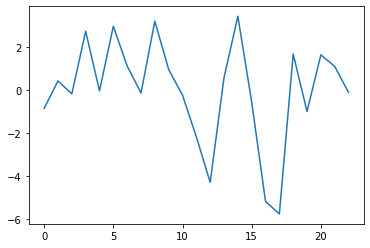

In [123]:
plt.plot(np.diff(np.array(P+result-W)[10]))

**INELASTIC DEMAND**

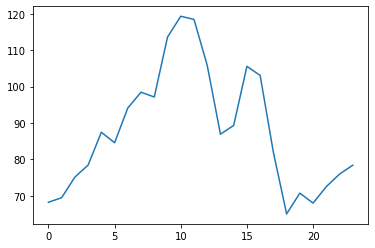

In [125]:
plt.plot(P[10])

**ELASTIC DEMAND ALLOCATED**

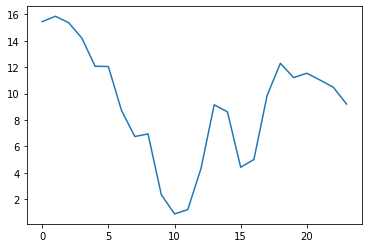

In [127]:
plt.plot(result[10])

**POWER SUPPLIED BY CONVENTIONAL SOURCES**

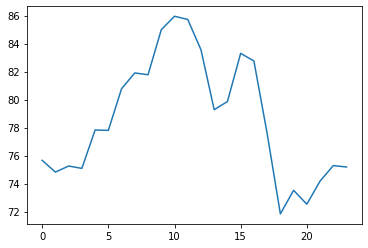

In [130]:
plt.plot((P+result-W)[10])

**RENEWABLE ENERGY SUPPLIED**

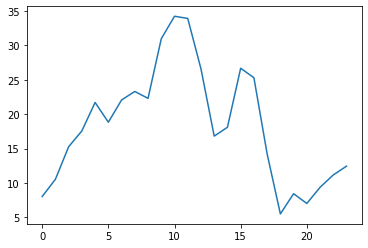

In [132]:
plt.plot(W[10])

In [67]:
plt.plot(np.diff(np.array(P+result-W)[10]))

**INELASTIC DEMAND OF THE FIRST 20 PROSUMERS OVER 24 HOURS**

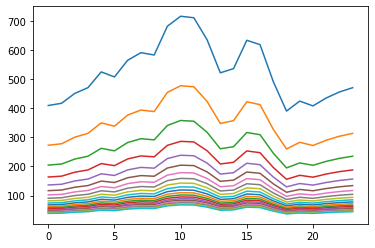

In [137]:
for i in range(20):
  plt.plot(P[i])

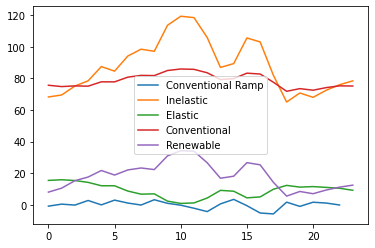

In [146]:
plt.plot(np.diff(np.array(P+result-W)[10]))
plt.plot(P[10])
plt.plot(result[10])
plt.plot((P+result-W)[10])
plt.plot(W[10])
plt.legend(['Conventional Ramp', 'Inelastic', 'Elastic', 'Conventional', 'Renewable'])